In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [5]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [7]:
for epoch in range(1, 5):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.354459 bn: 2.330301 drop: 2.337022 both: 2.397620
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.826075 bn: 0.695491 drop: 0.985353 both: 0.826320
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.551921 bn: 0.550409 drop: 0.687592 both: 0.690863
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.361147 bn: 0.327793 drop: 0.383219 both: 0.406143
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.306416 bn: 0.257765 drop: 0.424203 both: 0.330672
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.306624 bn: 0.258169 drop: 0.356723 both: 0.370376
Test set:
default: Loss: 0.3090	Accuracy: 9160.0/10000 (92%)
bn: Loss: 0.2710	Accuracy: 9244.0/10000 (92%)
drop: Loss: 0.3680	Accuracy: 9024.0/10000 (90%)
both: Loss: 0.3277	Accuracy: 9126.0/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.256078 bn: 0.249678 drop: 0.285317 both: 0.315843
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.260363 bn: 0.206966 drop: 0.322

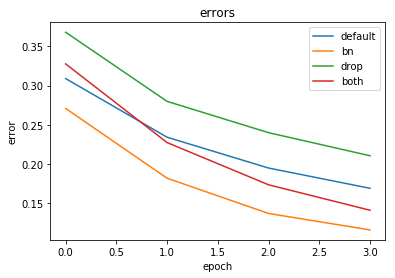

In [8]:
plot_graphs(test_log, 'loss')

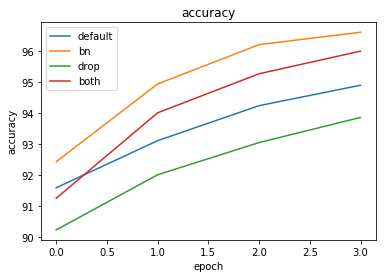

In [9]:
plot_graphs(test_log, 'accuracy')

In [10]:
test_log

{'default': [(0.3089977635860443, 91.6),
  (0.23430090143680574, 93.12),
  (0.19509919121265412, 94.25),
  (0.16933003885746004, 94.91)],
 'bn': [(0.27095521297454833, 92.44),
  (0.18211429884433747, 94.95),
  (0.13729065161943435, 96.22),
  (0.11634051321744919, 96.62)],
 'drop': [(0.3679665538787842, 90.24),
  (0.27994118423461917, 92.02),
  (0.2401254789829254, 93.06),
  (0.21075678479671478, 93.87)],
 'both': [(0.3276635898590088, 91.26),
  (0.2275113963842392, 94.02),
  (0.1737750594496727, 95.28),
  (0.14138351695537568, 96.01)]}